<a href="https://colab.research.google.com/github/m-aliabbas/Pneumonia-Train-Models-/blob/master/ResearchPaperResnet101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from fastai.vision import *
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
from zipfile import ZipFile 
def unZip(file_name):
  with ZipFile(file_name, 'r') as zip: 
      zip.extractall() 
      print('Done!') 

In [0]:
file_name = '/content/drive/chestXRay.zip'

In [0]:
path="/content/drive/My Drive/"
file_name=path+'chestXRay.zip'

In [0]:
unZip(file_name)

Done!


In [0]:
unZip('chest_xray.zip')

Done!


In [0]:
import glob
import cv2
import numpy as np
%matplotlib inline
filesPos= sorted(glob.glob('chest_xray/train/NORMAL/*.jpeg'))
filesPos+=sorted(glob.glob('chest_xray/val/NORMAL/*.jpeg'))
filesPos+=sorted(glob.glob('chest_xray/test/NORMAL/*.jpeg'))



In [0]:
filesNeg=sorted(glob.glob('chest_xray/train/PNEUMONIA/*.jpeg'))
filesNeg+=sorted(glob.glob('chest_xray/val/PNEUMONIA/*.jpeg'))
filesNeg+=sorted(glob.glob('chest_xray/test/PNEUMONIA/*.jpeg'))

In [0]:
random.shuffle(filesNeg)
len(filesPos),len(filesNeg)

(1583, 4273)

In [0]:
filesNeg=filesNeg[:2100]

In [0]:
pos_labels=[[i,0] for i in filesPos]
neg_labels=[[i,1] for i in filesNeg]
ds=pos_labels+neg_labels

In [0]:
np.random.seed(4200)
import pandas as pd 
df = pd.DataFrame(ds,columns =['path', 'label']) 
def Randomizing(df):
    df2 = df.reindex(np.random.permutation(df.index))
    return df2
df=Randomizing(df)

In [0]:
from sklearn.model_selection import train_test_split
dfTrain,dfTest=train_test_split(df, shuffle=False,test_size=0.1, random_state=42)

In [0]:
len(dfTrain),len(dfTest)

(3314, 369)

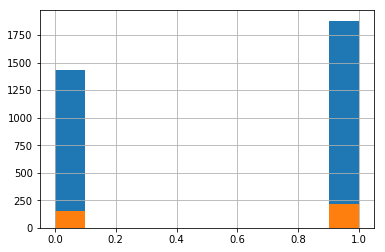

In [0]:
dfTrain['label'].hist()
dfTest['label'].hist()

In [0]:
bs =8
sz=224
tfms = get_transforms(do_flip=True,flip_vert=True,max_lighting=0.4,max_zoom=1.1)
src = (ImageList.from_df(df=dfTrain,path='',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.2) #Splitting the dataset
        .label_from_df(cols='label') #obtain labels from the level column
      )
data= (src.transform(tfms,size=224,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

In [0]:
data.classes

[0, 1]

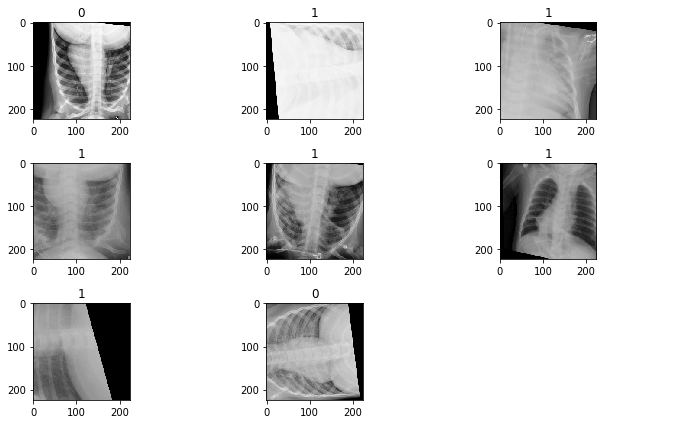

In [0]:
data.show_batch(rows=3, figsize=(10,6), hide_axis=False)

In [0]:
from sklearn.metrics import roc_auc_score,f1_score
def f1_score_a(y_pred,y_true,tens=True):
#     score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    f1a_score=f1_score(y_true, np.round(torch.sigmoid(y_pred)[:,1]), average='macro') 
    if tens:
#         score=tensor(score)
        f1a_score=tensor(f1a_score)
    else:
        f1a_score=f1a_score
    return f1a_score


In [0]:

import torch 
import torchvision
model = torchvision.models.resnet101(pretrained=True)

In [0]:
num_ftrs = model.fc.in_features
model.fc=nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, 128),
    nn.Dropout(0.5),
    nn.Linear(128, 2),
    
)

In [0]:
model=model.cuda()

In [0]:
from fastai.callbacks import *

learn = Learner(data, model, metrics=[error_rate, accuracy,f1_score_a],callback_fns=[partial(CSVLogger,append=True),BnFreeze, partial(GradientClipping, clip=0.2)])

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-04
Min loss divided by 10: 6.92E-05


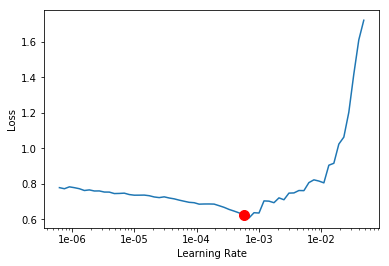

In [0]:
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr  if hasattr(learn, 'recorder') else 1e-2

In [0]:
from fastai.callbacks import *
learn.fit_one_cycle(5,min_grad_lr,callbacks=[SaveModelCallback(learn, every='imrpovement', monitor='f1_score_a')])

/usr/local/lib/python3.6/dist-packages/fastai/callbacks/tracker.py:83: UserWarning: SaveModel every imrpovement is invalid, falling back to "improvement".
  warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score_a,time
0,0.611015,0.436275,0.191843,0.808157,0.628412,03:35
1,0.527073,1.305464,0.410876,0.589124,0.433247,03:40
2,0.433116,0.269298,0.101208,0.898792,0.829435,03:34
3,0.331382,0.252080,0.074018,0.925982,0.897928,03:33
4,0.328979,0.218540,0.070997,0.929003,0.910237,03:33


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Better model found at epoch 0 with f1_score_a value: 0.6284124851226807.
Better model found at epoch 2 with f1_score_a value: 0.829434871673584.
Better model found at epoch 3 with f1_score_a value: 0.8979284763336182.
Better model found at epoch 4 with f1_score_a value: 0.9102371335029602.


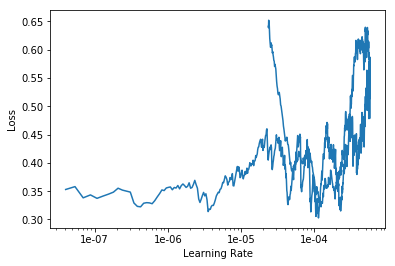

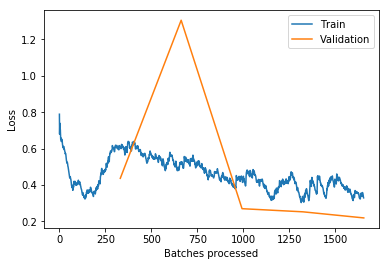

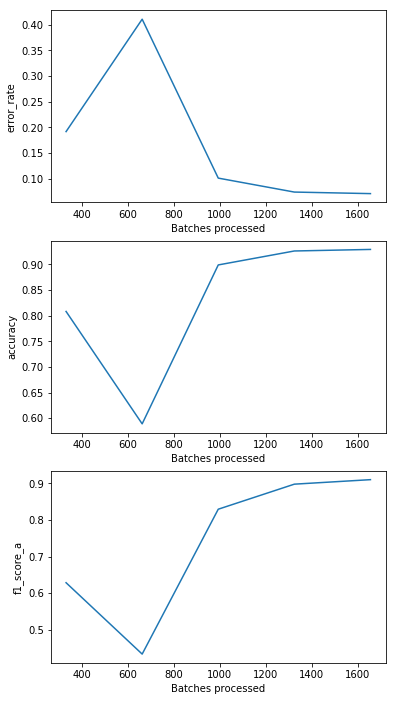

In [0]:
learn.recorder.plot()
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [0]:
learn.load('bestmodel')

Learner(data=ImageDataBunch;

Train: LabelList (2652 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,1,1,0
Path: .;

Valid: LabelList (662 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,1,1,0
Path: .;

Test: None, model=ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.32E-07


/usr/local/lib/python3.6/dist-packages/fastai/callbacks/tracker.py:83: UserWarning: SaveModel every imrpovement is invalid, falling back to "improvement".
  warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score_a,time
0,0.300488,0.233217,0.077039,0.922961,0.897197,03:38
1,0.278412,0.206175,0.069486,0.930514,0.909117,03:31
2,0.338798,0.201969,0.070997,0.929003,0.906945,03:28
3,0.418570,0.198721,0.063444,0.936556,0.918082,03:33
4,0.362781,0.208597,0.075529,0.924471,0.913660,03:27


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Better model found at epoch 0 with f1_score_a value: 0.8971969485282898.
Better model found at epoch 1 with f1_score_a value: 0.9091167449951172.
Better model found at epoch 3 with f1_score_a value: 0.9180824160575867.


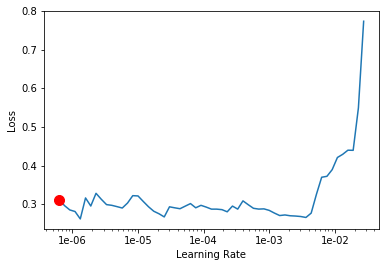

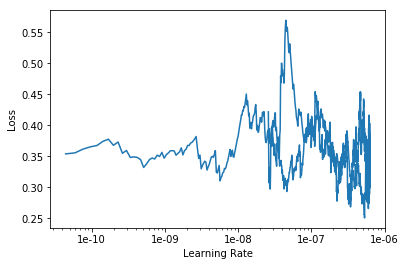

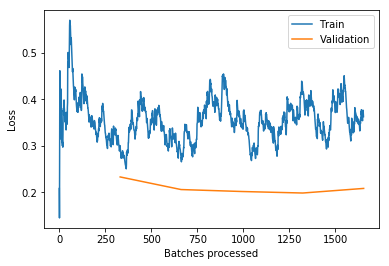

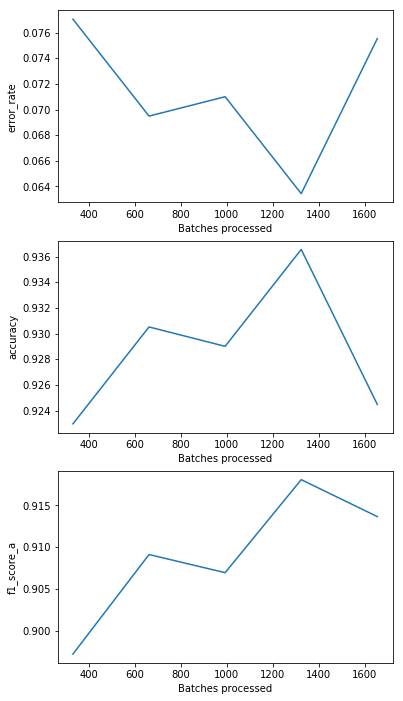

In [0]:
learn.load('bestmodel')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr  if hasattr(learn, 'recorder') else 1e-2
min_grad_lr
learn.fit_one_cycle(5,min_grad_lr,callbacks=[SaveModelCallback(learn, every='imrpovement', monitor='f1_score_a')])
learn.recorder.plot()
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

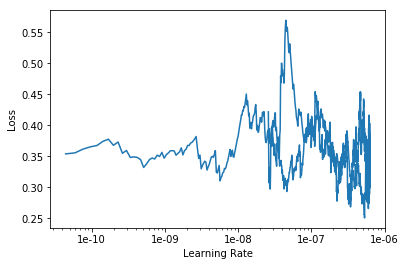

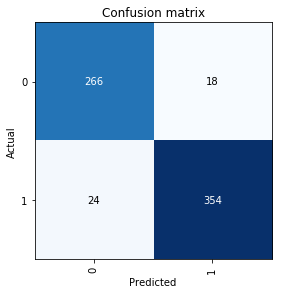

In [0]:
learn.recorder.plot()
learn.load('bestmodel')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

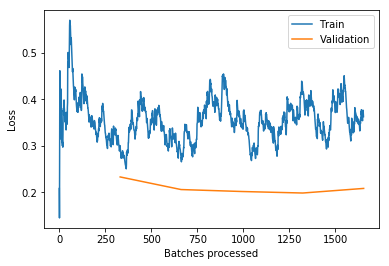

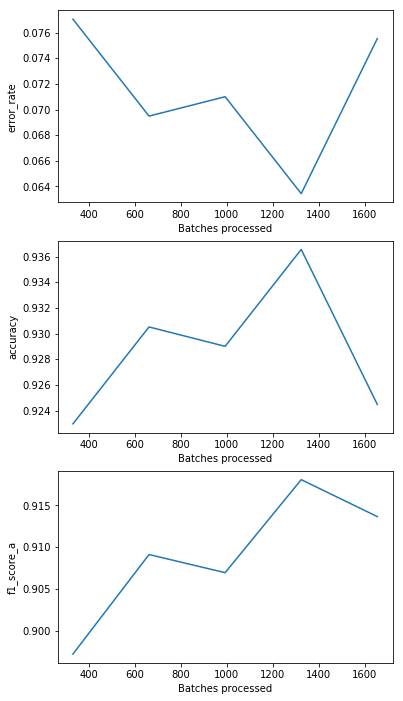

In [0]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

Precision of Model = 0.9365079365079365 Recall of Model  0.9516129032258065
F1 Score of Model = 0.944


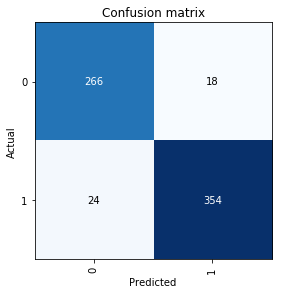

In [0]:
learn.load('bestmodel')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
conf=interp.confusion_matrix()
TrueNagitive=conf[0][0]
FalseNegative=conf[0][1]
TruePositive=conf[1][1]
FalsePositive=conf[1][0]
recal=TruePositive/(TruePositive+FalseNegative)
precision=TruePositive/(TruePositive+FalsePositive)
print("Precision of Model =",precision,"Recall of Model ", recal)
f1=2*((precision*recal)/(precision+recal))
print('F1 Score of Model =',f1)

In [0]:
bs =8
sz=224
tfms = get_transforms(do_flip=True,flip_vert=True,max_lighting=0.4,max_zoom=1.1)
src = (ImageList.from_df(df=dfTest,path='',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.0) #Splitting the dataset
        .label_from_df(cols='label') #obtain labels from the level column
      )
data= (src.transform(tfms,size=224,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

In [0]:
learn.data.valid_dl = data.train_dl

In [0]:
learn.validate()

[0.3264713, tensor(0.1033), tensor(0.8967), tensor(0.8945)]

Precision of Model = 0.9636363636363636 Recall of Model  0.9098712446351931
F1 Score of Model = 0.9359823399558498


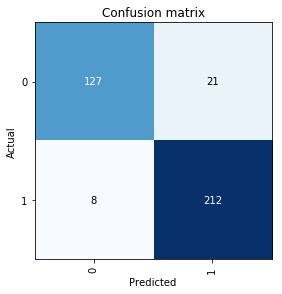

In [0]:
learn.load('bestmodel')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
conf=interp.confusion_matrix()
TrueNagitive=conf[0][0]
FalseNegative=conf[0][1]
TruePositive=conf[1][1]
FalsePositive=conf[1][0]
recal=TruePositive/(TruePositive+FalseNegative)
precision=TruePositive/(TruePositive+FalsePositive)
print("Precision of Model =",precision,"Recall of Model ", recal)
f1=2*((precision*recal)/(precision+recal))
print('F1 Score of Model =',f1)

In [0]:
TrueNagitive,FalseNegative,TruePositive,FalsePositive

(127, 21, 212, 8)

In [0]:
!ls

chest_xray  chest_xray.zip  drive  history.csv	__MACOSX  models  sample_data


In [0]:
!mkdir '/content/drive/My Drive/Resnet101Pne'
!cp 'models/bestmodel.pth' '/content/drive/My Drive/Resnet101Pne'
!cp 'history.csv' '/content/drive/My Drive/Resnet101Pne'

mkdir: cannot create directory ‘/content/drive/My Drive/Resnet101Pne’: File exists
